# Maximum Likelihood Method



Lets start with a simple Gaussian distribution. 

In [199]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')

<IPython.core.display.Javascript object>

We can retrieve the probability of events happening, e.g. x=3.0

In [200]:
p_3 = norm.pdf(3.0, 5.0, 3.0)

We can also easily calculate the joint probability of iid (indepenent and identically distributed) events 

In [201]:
p_7 = norm.pdf(7.0, 7.0, 3.0)

joint = p_3*p_7

Assume now that someone is giving us an array of values and ask us to estimate a $p_{model}$ that is a 'good fit' to the gievn data. How we can go about solving this problem with Maximum Likelihood Estimation (MLE)? Notice that as addressed in [3], probability and likelihood have a reverse relationship.  Probability attaches to possible results; likelihood attaches to hypotheses. The likelihood function gives the relative likelihoods of different values for the parameter(s) of the distribution from which the data are assumed to have been drawn, given those data.

Lets plot a couple of $p_{model}$ hypotheses - the data are shown below in the same plot. Both hypotheses are plausible.  

In [202]:
data = [4, 5, 7, 8, 8, 9, 10, 5, 2, 3, 5, 4, 8, 9]

fig, ax = plt.subplots(1, 1)
x = np.linspace(0, 20, 100) 
ax.plot(x, norm.pdf(x,5,3),
       'r-', lw=5, alpha=0.6, label='norm pdf')
ax.plot(x, norm.pdf(x,7,3),
       'b-', lw=5, alpha=0.6, label='norm pdf')
ax.plot(data, np.zeros(len(data)).tolist(),'o')

<IPython.core.display.Javascript object>

As detailed in Ref [2], its important to safeguard against underflow that may well result from multiplying many numbers (for large datasets) that are less than 1.0 (probabilities). So we do the calculations in the log domain using the identity

$$log(a \times b)=log(a) + log(b)$$

Lets look at a function that calculates the log-likelihood for the two hypotheses above given the data denoted by $x$. 

In [203]:
def compare_data_to_dist(x, mu_1=5, mu_2=7, sd_1=3, sd_2=3):
    ll_1 = 0
    ll_2 = 0
    for i in x:
        ll_1 += np.log(norm.pdf(i, mu_1, sd_1))
        ll_2 += np.log(norm.pdf(i, mu_2, sd_2))
    
    print("The LL of of x for mu = %d and sd = %d is: %.4f" % (mu_1, sd_1, ll_1))
    print("The LL of of x for mu = %d and sd = %d is: %.4f" % (mu_2, sd_2, ll_2))


We can readily compate the two hypotheses according to the maximum likelihood criterion. Note that because the $log$ is a monotonic function, the conclusion as to which hypothesis makes the data more likely is the same in the natural or the $log$ domain. 

In [204]:
ll_comparison = compare_data_to_dist(data)

The LL of of x for mu = 5 and sd = 3 is: -33.9679
The LL of of x for mu = 7 and sd = 3 is: -33.3013


It seems that the second hypothesis 

$$p_{model}(x|\mathbf{w}) = N(x | [\mu_2, \sigma_2^2])$$

is preferred compared to the first. 

We can now start searching the hypothesis space (parameter space) for the best parameter set $\mathbf w$. 

In [205]:
# Plot the Negative Log Likelihood Functions for different values of mu 
# and sigma
def plot_ll(x):
    plt.figure(figsize=(5,8))
    plt.title("Neg Log Likelihood Functions")
    plt.xlabel("Mean Estimate")
    plt.ylabel("Neg Log Likelihood")
    plt.ylim(30, 60)
    plt.xlim(0, 12)
    mu_set = np.linspace(0, 16, 1000)
    sd_set = [.5, 1.5, 2.5, 3.5, 4.5]
    max_val = max_val_location = None
    for i in sd_set:
        ll_array = []
        
        for j in mu_set:
            temp_mm = 0
            
            for k in x:
                temp_mm += np.log(norm.pdf(k, j, i)) # The LL function
            ll_array.append(-temp_mm) # negative LL
        
            if (max_val is None):
                max_val = min(ll_array)
            elif max(ll_array) > max_val:
                max_val = min(ll_array)
                max_val_location = j
        
        # Plot the results
        plt.plot(mu_set, ll_array, label="sd: %.1f" % i)
        
        print("The max LL for sd %.2f is %.2f" % (i, min(ll_array)))    
    plt.axvline(x=max_val_location, color='black', ls='-.')
    plt.legend(loc='lower left')
plot_ll(data);


<IPython.core.display.Javascript object>

The max LL for sd 0.50 is 167.88
The max LL for sd 1.50 is 36.84
The max LL for sd 2.50 is 32.28
The max LL for sd 3.50 is 33.77
The max LL for sd 4.50 is 35.96


But there is a better method than exhaustively searching in the parameter space. We developed a method that incrementally minimizes a loss function that is ultimately linked to the concept of entropy - the cross entropy (CE) that for the supervided learning problem as shown in the notes has a lot to do with minimizing the KL divergence - a type of probabilistic 'distance' between $\hat p_{data}$ and $p_{model}$. 

This method is the Stochastic Gradient Descent. Can ypu estimate the hypothesis for the `data` array above? 

<IPython.core.display.Javascript object>


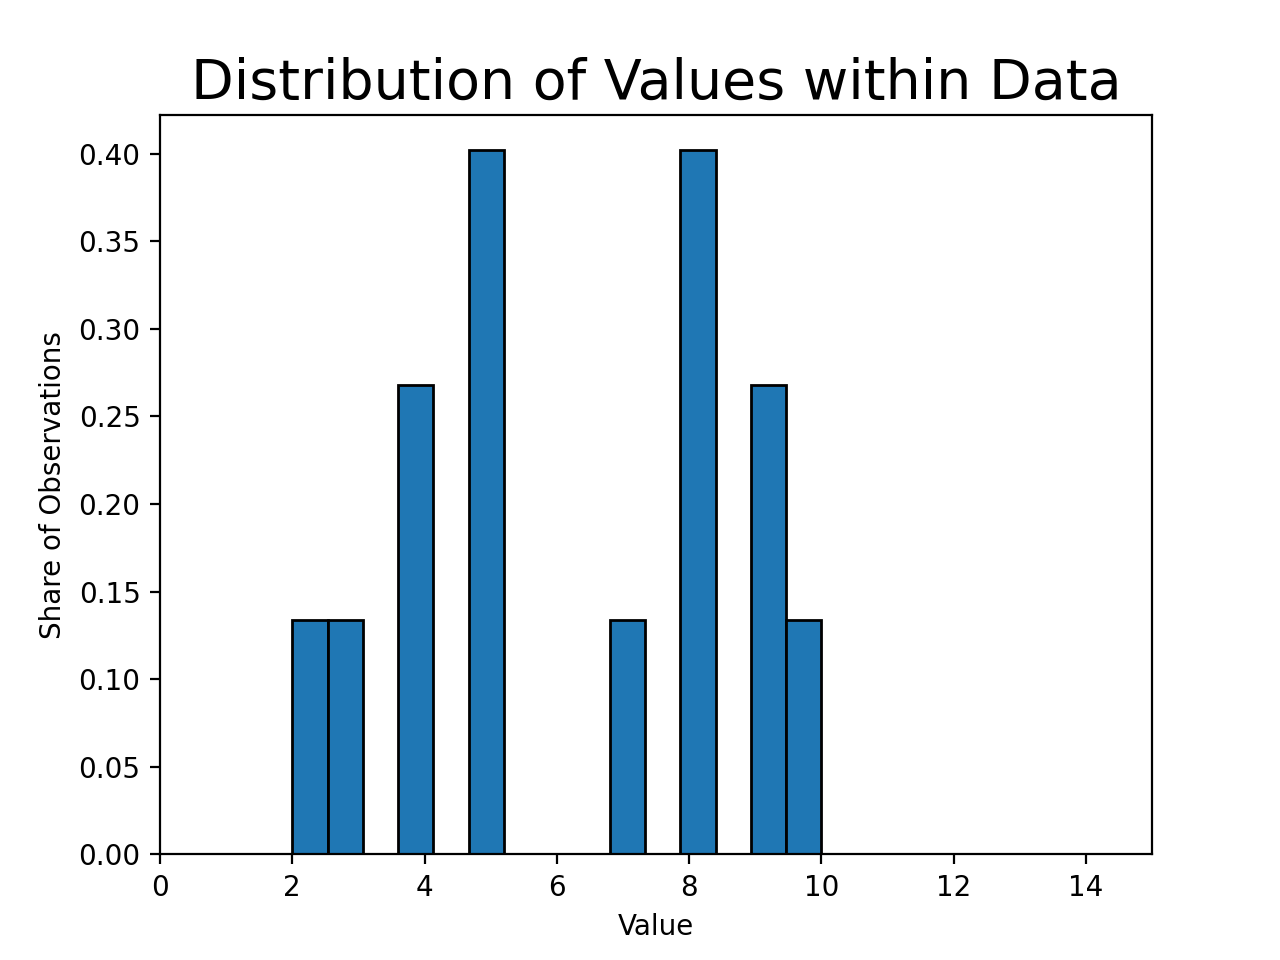

In [1]:
# STEPS to estimate the Hypothesis
#1 - Initialize mu and sd with random values
#2 - calculate gradients of mu and sd using the initialized mu and sd
#3 - adjust mu and sd with partial derivatives
#4 - repeat #2 and #3 for n numbers of iteration

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.stats import truncnorm
import scipy.stats as sts
import requests
#^^^ importing Modules ^^^




# Transform  data into a NumPy array
pts = np.array([4, 5, 7, 8, 8, 9, 10, 5, 2, 3, 5, 4, 8, 9])

%matplotlib notebook

num_bins = 15
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title('Distribution of Values within Data', fontsize=20)
plt.xlabel(r'Value')
plt.ylabel(r'Share of Observations')
plt.xlim([0, 15])  # This gives the xmin and xmax to be plotted"

plt.show()


In [2]:
# Define function that generates values of a normal pdf
def trunc_norm_pdf(xvals, mu, sigma, cut_lb, cut_ub):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the normal pdf with mean mu and standard
    deviation sigma. If the cutoff is given, then the PDF values are
    inflated upward to reflect the zero probability on values above the
    cutoff. If there is no cutoff given, this function does the same
    thing as sp.stats.norm.pdf(x, loc=mu, scale=sigma).
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    prob_notcut = scalar 
    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.norm.cdf(cut_lb, loc=mu, scale=sigma)
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.norm.cdf(cut_ub, loc=mu, scale=sigma)
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.norm.cdf(cut_ub, loc=mu, scale=sigma) -
                       sts.norm.cdf(cut_lb, loc=mu, scale=sigma))
            
    pdf_vals    = ((1/(sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (xvals - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

<IPython.core.display.Javascript object>


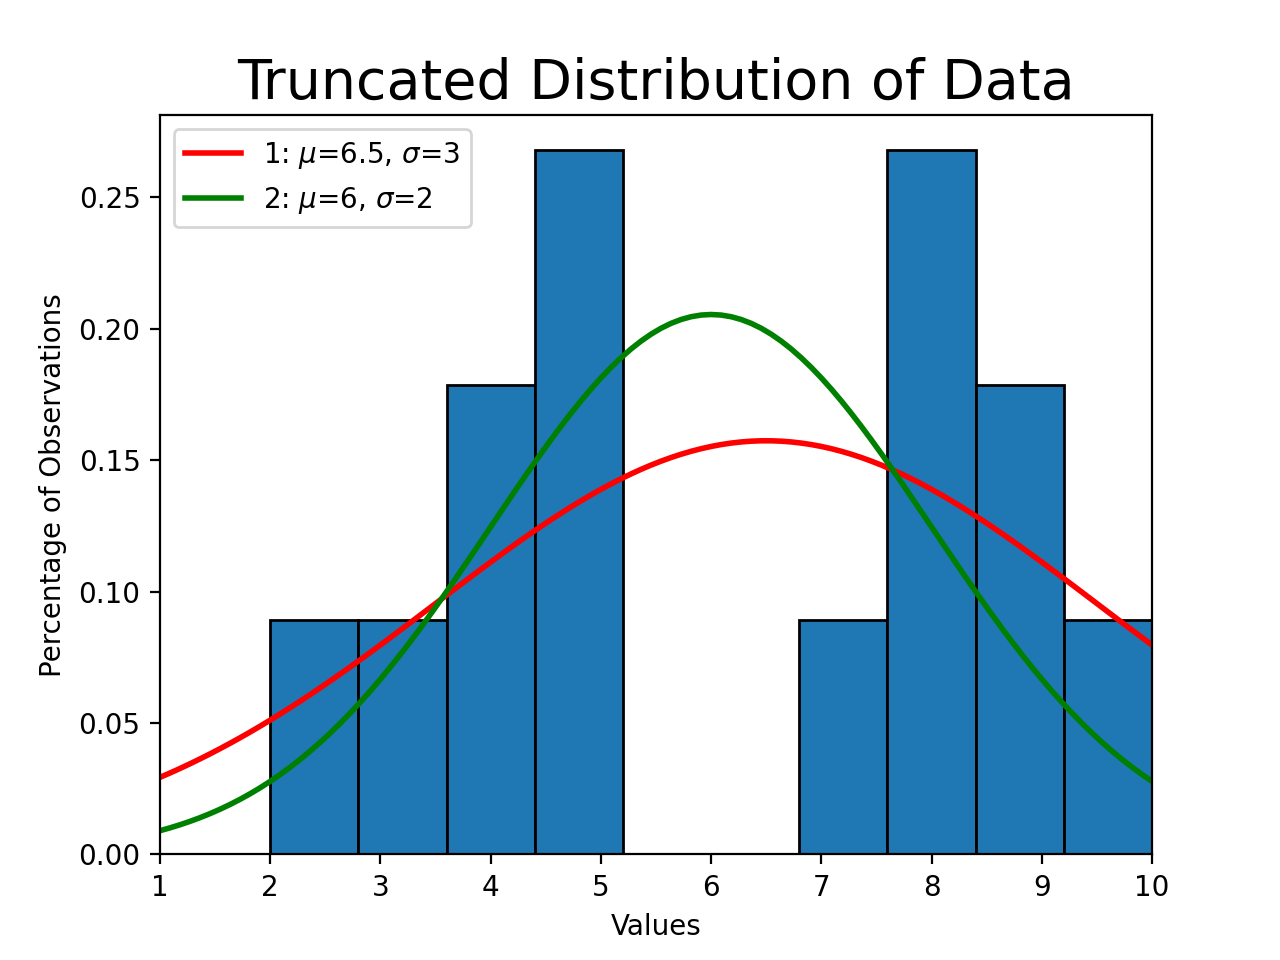

In [3]:
#STEP 1 - Initialize mu and sd with random values
# Plot two different truncated Gaussian distributions N(6.5, 3) and N(6, 2) on top of the histogram of the data

%matplotlib notebook

# Plot histogram
num_bins = 10
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title('Truncated Distribution of Data', fontsize=20)
plt.xlabel(r'Values')
plt.ylabel(r'Percentage of Observations')
plt.xlim([1, 10])  # This gives the xmin and xmax to be plotted"

# Plot smooth line with distribution 3
dist_pts = np.linspace(1, 10, 100)
mu_1 = 6.5
sig_1 = 3
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_1, sig_1, 1, 10),
         linewidth=2, color='r', label='1: $\mu$=6.5, $\sigma$=3')
plt.legend(loc='upper left')

# Plot smooth line with distribution 2
mu_2 = 6
sig_2 = 2
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_2, sig_2, 1, 10),
         linewidth=2, color='g', label='2: $\mu$=6, $\sigma$=2')
plt.legend(loc='upper left')

In [4]:
# Defining the log likelihood function for the normal distribution
def log_lik_truncnorm(xvals, mu, sigma, cut_lb, cut_ub):
    '''
    --------------------------------------------------------------------
    Compute the log likelihood function for data xvals given normal
    distribution parameters mu and sigma.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    pdf_vals    = (N,) vector, normal PDF values for mu and sigma
                  corresponding to xvals data
    ln_pdf_vals = (N,) vector, natural logarithm of normal PDF values
                  for mu and sigma corresponding to xvals data
    log_lik_val = scalar, value of the log likelihood function
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: log_lik_val
    --------------------------------------------------------------------
    '''
    pdf_vals = trunc_norm_pdf(xvals, mu, sigma, cut_lb, cut_ub)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

print('Log-likelihood 1: ', log_lik_truncnorm(pts, mu_1, sig_1, 1, 40))
print('Log-likelihood 2: ', log_lik_truncnorm(pts, mu_2, sig_2, 1, 40))


Log-likelihood 1:  -32.40935337542152
Log-likelihood 2:  -32.856993635902604


In [7]:
#Defining our Learning Rate's scalar function
def crit(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 2 tuple, (xvals, cutoff)
    xvals  = (N,) vector, values of the normally distributed random
             variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        log_lik_truncnorm()
    
    OBJECTS CREATED WITHIN FUNCTION:
    log_lik_val = scalar, value of the log likelihood function
    neg_log_lik_val = scalar, negative of log_lik_val
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: neg_log_lik_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cut_lb, cut_ub = args
    log_lik_val = log_lik_truncnorm(xvals, mu, sigma, cut_lb, cut_ub)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [8]:

import scipy.optimize as opt

#STEP 2 - calculating gradients of mu and sd using the initialized mu and sd
mu_init = 6  # mu_2
sig_init = 2  # sig_2
params_init = np.array([mu_init, sig_init])
mle_args = (pts, 0, 40)
#STEP 3 - adjusting mu and sd with partial derivatives
#STEP 4 - repeat #2 and #3 for n numbers of iteration
results_uncstr = opt.minimize(crit, params_init, args=(mle_args))
mu_MLE, sig_MLE = results_uncstr.x
print('mu_MLE=', mu_MLE, ' sig_MLE=', sig_MLE)



mu_MLE= 6.168727662319753  sig_MLE= 2.483095679840315


In [9]:
results_uncstr

      fun: 32.18800057111274
 hess_inv: array([[ 0.47188789, -0.03589092],
       [-0.03589092,  0.26612454]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 7
     njev: 10
   status: 0
  success: True
        x: array([6.16872766, 2.48309568])

<IPython.core.display.Javascript object>


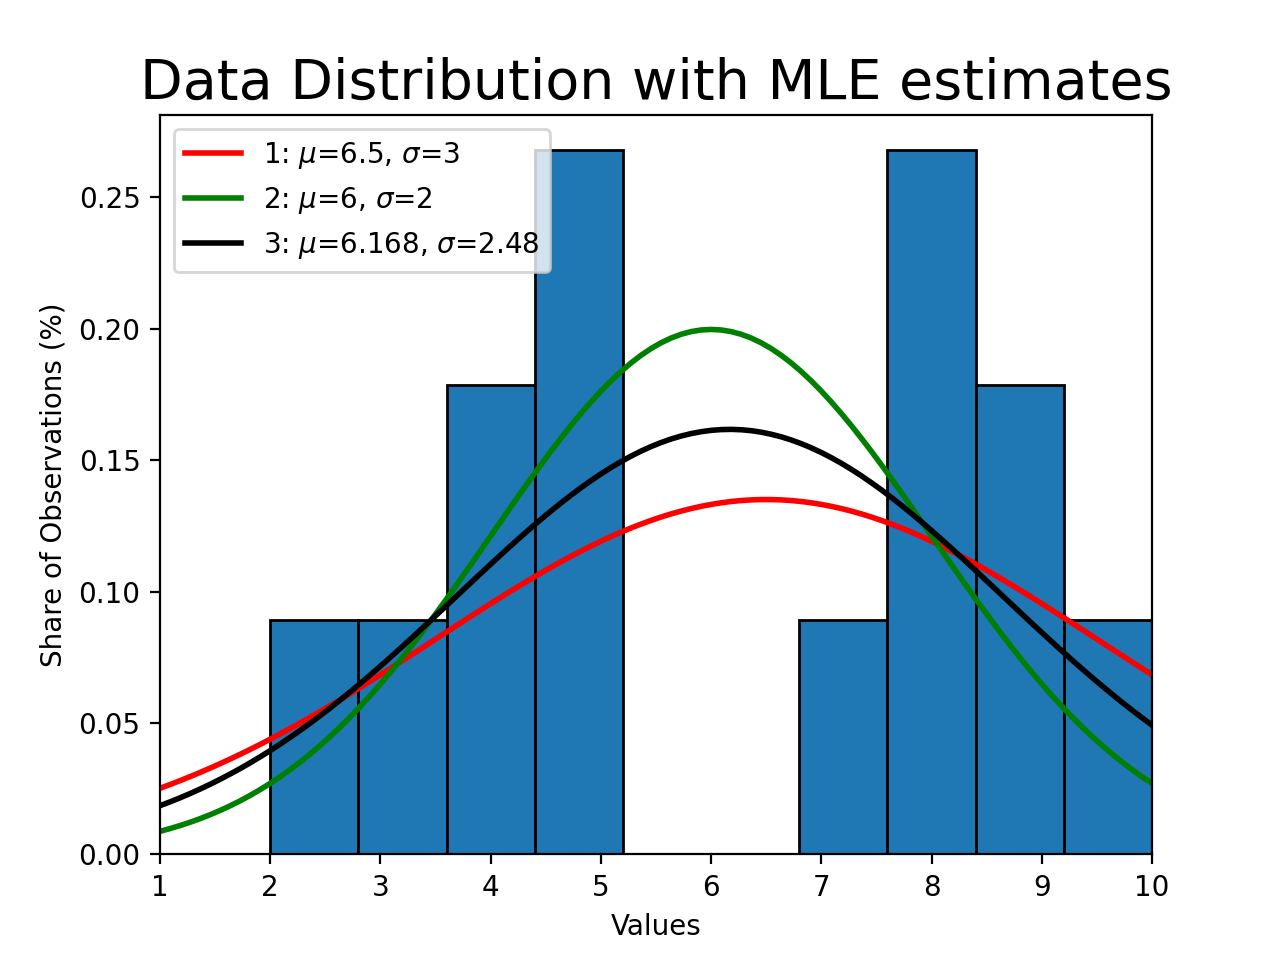

In [10]:
# Plot the histogram of the data
%matplotlib notebook
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title('Data Distribution with MLE estimates', fontsize=20)
plt.xlabel(r'Values')
plt.ylabel(r'Share of Observations (%)')
plt.xlim([1, 10])  # This gives the xmin and xmax to be plotted"

# Plot the two test distributions from before
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_1, sig_1, 0, 40),
         linewidth=2, color='r', label='1: $\mu$=6.5, $\sigma$=3')
plt.legend(loc='upper left')

plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_2, sig_2, 0, 40),
         linewidth=2, color='g', label='2: $\mu$=6, $\sigma$=2')
plt.legend(loc='upper left')

# Plot the MLE estimated distribution
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_MLE, sig_MLE, 0, 40),
         linewidth=2, color='k', label='3: $\mu$=6.168, $\sigma$=2.48')
plt.legend(loc='upper left')
#plt.savefig('images/MLEplots.png')

In [11]:
print('Log-likelihood 1: ', log_lik_truncnorm(pts, mu_1, sig_1, 0, 450))
print('Log-likelihood 2: ', log_lik_truncnorm(pts, mu_2, sig_2, 0, 450))
print('MLE log-likelihood 3: ', log_lik_truncnorm(pts, mu_MLE, sig_MLE, 0, 450))

Log-likelihood 1:  -32.6711596378339
Log-likelihood 2:  -32.92528865319817
MLE log-likelihood 3:  -32.18800057111274


<IPython.core.display.Javascript object>


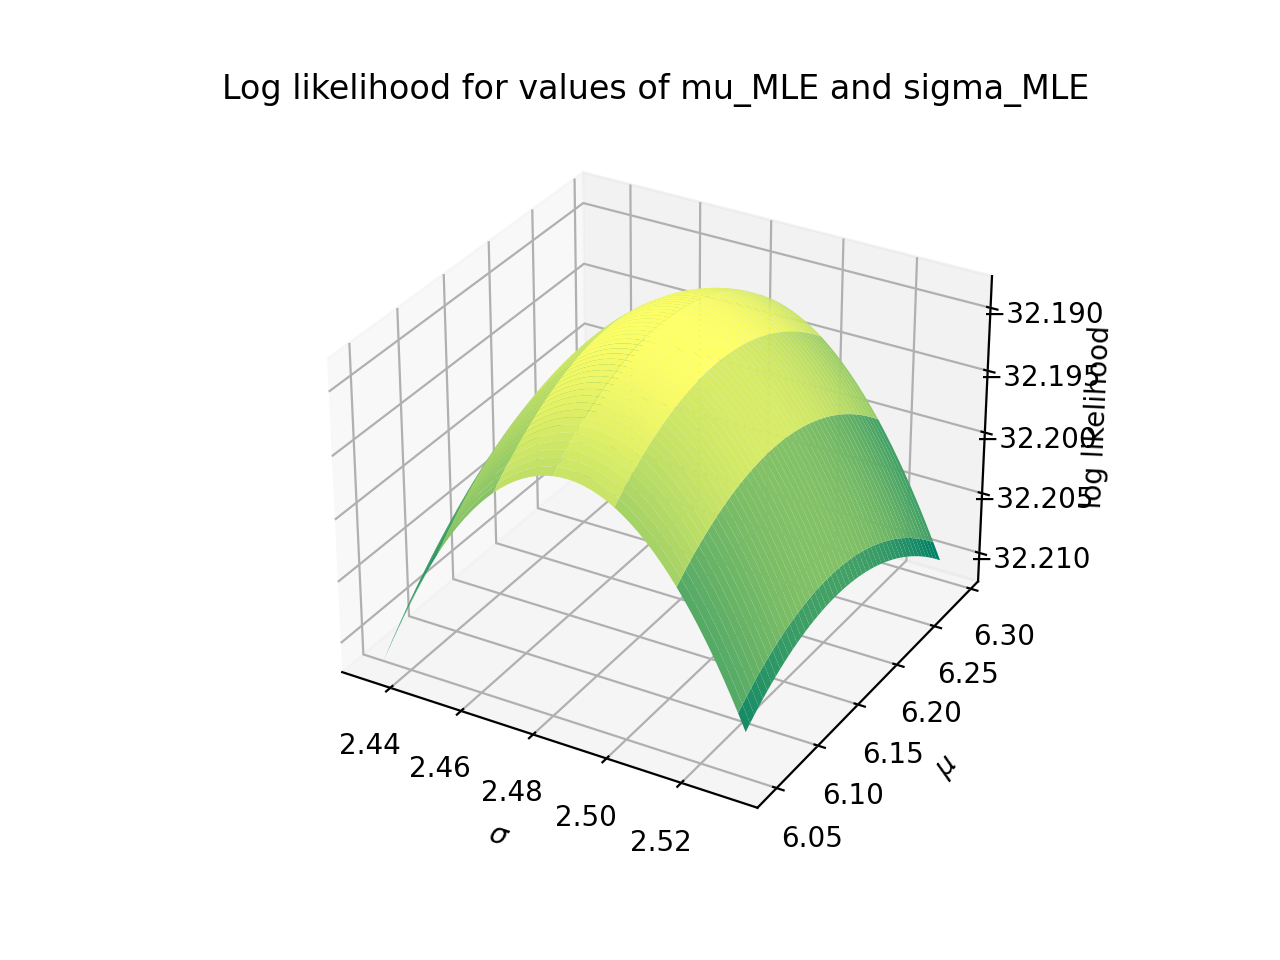

Text(0.5, 0, 'log likelihood')

In [12]:
%matplotlib notebook
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')

#mu_vals = np.linspace(mu_MLE - 1, mu_MLE + 1, 50)
#sig_vals = np.linspace(sig_MLE - 1, sig_MLE + 1, 50)
mu_vals = np.linspace(0.98*mu_MLE, 1.02*mu_MLE, 50)
sig_vals = np.linspace(0.98*sig_MLE, 1.02*sig_MLE, 50)
lnlik_vals = np.zeros((50, 50))
for mu_ind in range(50):
    for sig_ind in range(50):
        lnlik_vals[mu_ind, sig_ind] = \
            log_lik_truncnorm(pts, mu_vals[mu_ind],
                              sig_vals[sig_ind], 0, 450)

mu_mesh, sig_mesh = np.meshgrid(mu_vals, sig_vals)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(sig_mesh, mu_mesh, lnlik_vals, rstride=8,
                cstride=1, cmap=cmap1)
ax.set_title('Log likelihood for values of mu_MLE and sigma_MLE')
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$\mu$')
ax.set_zlabel(r'log likelihood')


You are given a problem that involves the relationship between $x$ and $y$. Estimate the parameters of a $p_{model}$ that fit the dataset (x,y) shown below.  

In [14]:
import numpy as np 
import matplotlib.pyplot as plt 
import numpy as np
import scipy.stats as sts
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score 
import statsmodels.api as sm 
from sklearn import preprocessing

%matplotlib notebook

# we always talk about vector notation as (mx1) in ML
x = np.array([[8, 16, 22, 33, 50, 51]]).T
y = np.array([[5, 20, 14, 32, 42, 58]]).T

scaler_x = preprocessing.StandardScaler().fit(x)
scaler_y = preprocessing.StandardScaler().fit(y)
m = len(x)

X_b = np.c_[np.ones((m, 1)), x]
print(X_b)
X_b = scaler_x.transform(X_b)
print(X_b)
y = scaler_y.transform(y)
print(y)


# MLE estimate (closed formula is possible for tiny datasets)
w_MLE = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
print('w_MLE = ', w_MLE)
plt.plot(X_b[:,1], y, "b.")
X_new = np.array([[-2], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(w_MLE)
plt.plot(X_new, y_predict)

def plot_gradient_descent(w, eta, w_path=False):
    m = len(X_b)
    plt.plot(X_b[:,1], y, "b.")
    n_iterations = 100
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(w)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradient = np.array([[1,1]]) #I know that we need to adjust this gradient, but I just don't know to what
        w = w - eta * gradient 
        if w_path is not None:
            w_path.append(w)
    plt.xlabel("$x$", fontsize=18)
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)
np.random.seed(42) 
w = np.random.randn(2,1)  # random initialization
print('Initial w = ', w)

w_path_bgd = []
plt.figure(figsize=(10,4)) 
plot_gradient_descent(w, eta=0.1)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.show()

[[ 1.  8.]
 [ 1. 16.]
 [ 1. 22.]
 [ 1. 33.]
 [ 1. 50.]
 [ 1. 51.]]


ValueError: X has 2 features, but StandardScaler is expecting 1 features as input.

# References

1. https://medium.com/@rrfd/what-is-maximum-likelihood-estimation-examples-in-python-791153818030
2. [Section 4.1 - Numerical computation](https://www.deeplearningbook.org/contents/numerical.html)
3. [Bayes for beginners - probability and likelihood](https://www.psychologicalscience.org/observer/bayes-for-beginners-probability-and-likelihood) 